In [3]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
from sklearn.decomposition import FastICA, KernelPCA, RandomizedPCA
from sklearn import pipeline
from sklearn.preprocessing import StandardScaler

Populating the interactive namespace from numpy and matplotlib


In [18]:
states = np.load("./checkpoints_greedy_bot/greedy_states_no_repeat_300fwd.npy")
actions = np.load("./checkpoints_greedy_bot/greedy_actions_no_repeat_300fwd.npy")
mask = (states[:, 35] != 0)
masked_states = states[mask]
norm_states = masked_states[:, :35] / masked_states[:, 35, np.newaxis]

In [25]:
pca = RandomizedPCA(n_components=2)
transformed = pca.fit_transform(states)

In [26]:
print(pca.explained_variance_ratio_)

[ 0.13732053  0.13164395]


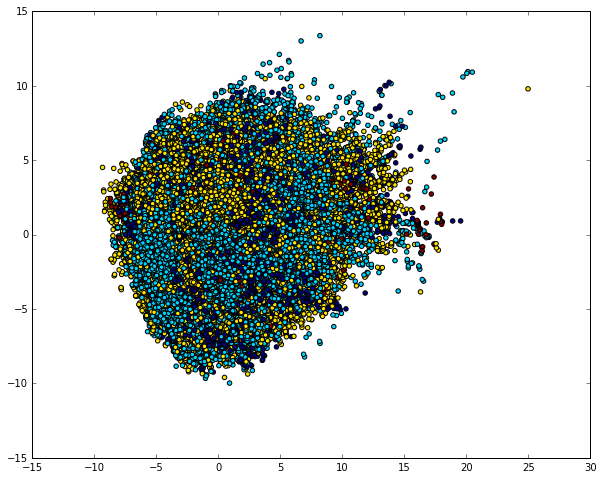

In [27]:
scatter(x=transformed[:, 0], y=transformed[:, 1], c=actions)

In [28]:
norm_pca = RandomizedPCA(n_components=2)
norm_transformed = norm_pca.fit_transform(norm_states)
print(norm_pca.explained_variance_ratio_)

[ 0.14095371  0.11854351]


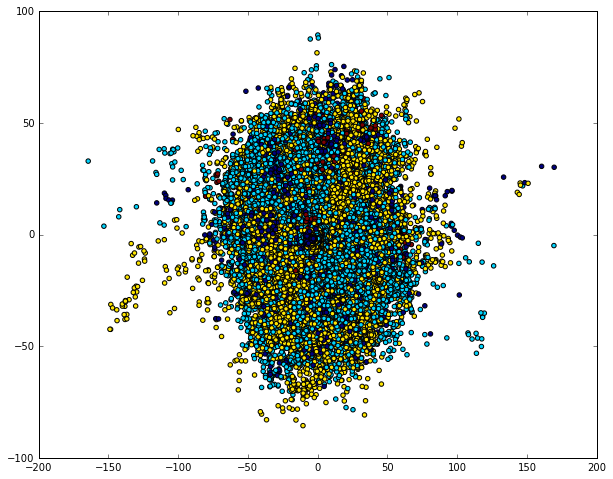

In [29]:
scatter(x=norm_transformed[:, 0], y=norm_transformed[:, 1], c=actions[mask])

In [19]:
norm2_pca = pipeline.make_pipeline(StandardScaler(), RandomizedPCA(n_components=2, random_state=119))
norm2_pca_transformed = norm2_pca.fit_transform(norm_states)

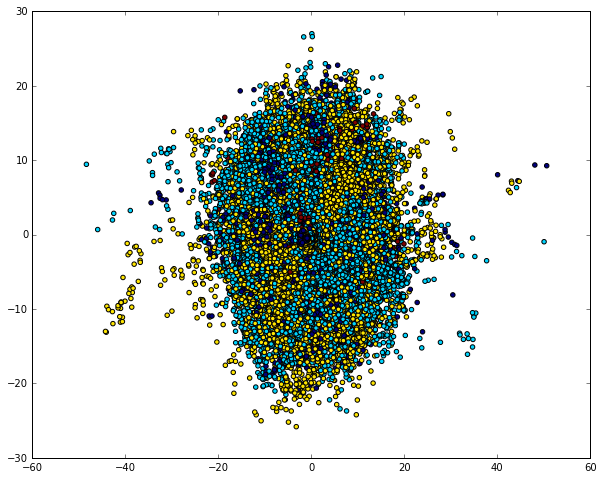

In [20]:
scatter(x=norm2_pca_transformed[:, 0], y=norm2_pca_transformed[:, 1], c=actions[mask])

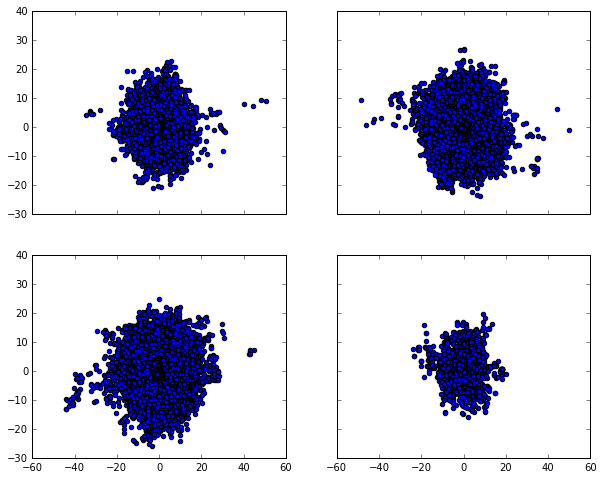

In [21]:
f, axarr = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
for i in range(4):
    action_mask = (actions[mask] == i)
    points = norm2_pca_transformed[:, :2][action_mask]
    axarr[i // 2][i % 2].scatter(x=points[:, 0], y=points[:, 1])

# ICA

In [22]:
norm_ica = FastICA(random_state=119, n_components=2)
norm_ica_transformed = norm_ica.fit_transform(norm_states)

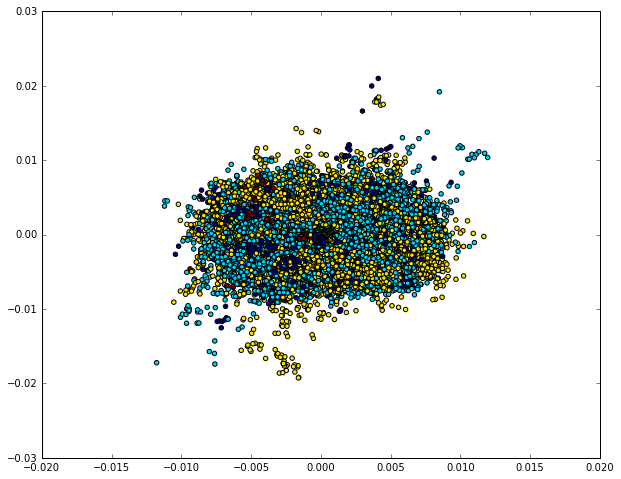

In [23]:
scatter(x=norm_ica_transformed[:, 0], y=norm_ica_transformed[:, 1], c=actions[mask])

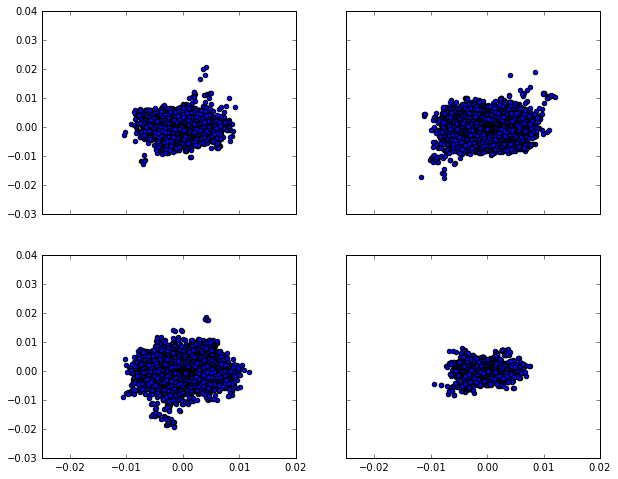

In [24]:
f, axarr = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
for i in range(4):
    action_mask = (actions[mask] == i)
    points = norm_ica_transformed[:, :2][action_mask]
    axarr[i // 2][i % 2].scatter(x=points[:, 0], y=points[:, 1])

In [47]:
norm2_ica = pipeline.make_pipeline(StandardScaler(), FastICA(n_components=2, random_state=119))
norm2_ica_transformed = norm2_ica.fit_transform(norm_states)

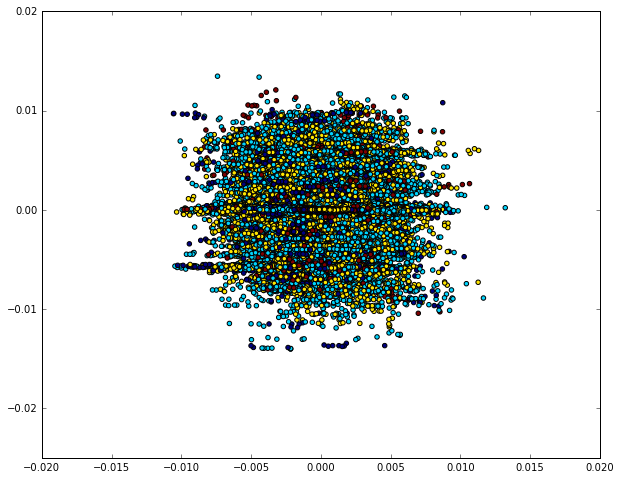

In [48]:
scatter(x=norm2_ica_transformed[:, 0], y=norm2_ica_transformed[:, 1], c=actions[mask])

In [36]:
np.random.seed(37)
small_mask = np.random.choice(np.arange(len(norm_states)), size=3000)
small_norm_states = norm_states[small_mask]
small_actions = actions[small_mask]

In [50]:
norm_kernel_pca = KernelPCA(n_components=2, kernel='poly', degree=2)
small_norm_kernel_transformed = norm_kernel_pca.fit_transform(small_norm_states)
norm_kernel_transformed = norm_kernel_pca.transform(norm_states)

MemoryError: 

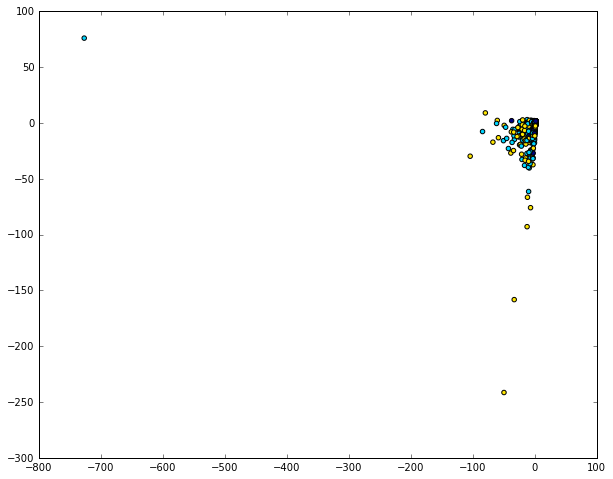

In [51]:
scatter(x=small_norm_kernel_transformed[:, 0], y=small_norm_kernel_transformed[:, 1], c=small_actions)

In [ ]:
f, axarr = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
for i in range(4):
    action_mask = (small_actions == i)
    points = small_norm_kernel_transformed[:, :2][action_mask]
    axarr[i // 2][i % 2].scatter(x=points[:, 0], y=points[:, 1])

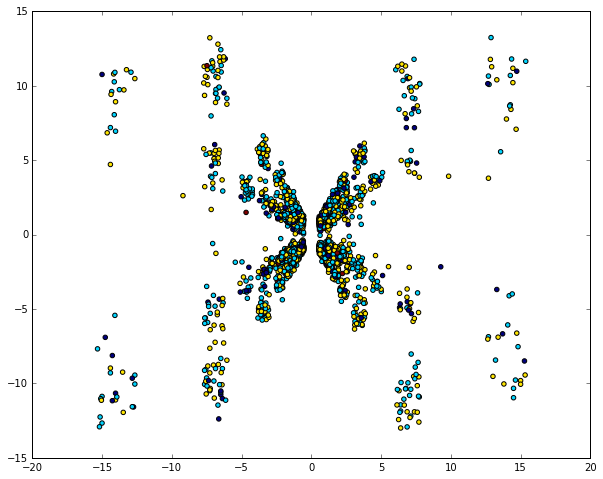

In [45]:
scatter(x=small_norm_states[:, 0], y=small_norm_states[:, 1], c=small_actions)

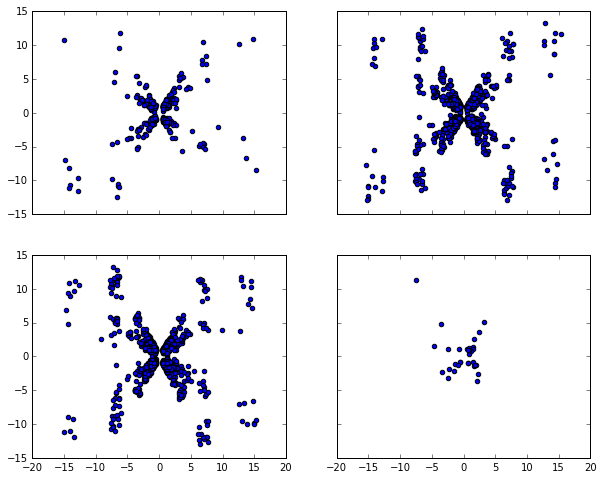

In [43]:
f, axarr = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
for i in range(4):
    action_mask = (small_actions == i)
    points = small_norm_states[:, :2][action_mask]
    axarr[i // 2][i % 2].scatter(x=points[:, 0], y=points[:, 1])

In [ ]:
scatter(x=norm_states[:, 0], y=norm_states[:, 1], c=actions[small_mask])